1. Найти датасет на hugging face, который будет содержать в себе числовые данные (> 3 числовых признаков)
2. Очистить данные от выбросов методами, рассмотренными на практическом занятии
3. Произвести отбор признаков одним из способов, рассмотренных на лекционной части занятия

## 0. import

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from scipy import stats
import os

In [125]:
SEED = 42
Z_THRESHOLD = 2.8

ROWS = 1000

## 1. dataset

In [126]:
X = pd.read_csv("../data/medical_insurance.csv")

if ROWS > 0:
    X = X[:ROWS]

In [127]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_id                    1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   sex                          1000 non-null   object 
 3   region                       1000 non-null   object 
 4   urban_rural                  1000 non-null   object 
 5   income                       1000 non-null   float64
 6   education                    1000 non-null   object 
 7   marital_status               1000 non-null   object 
 8   employment_status            1000 non-null   object 
 9   household_size               1000 non-null   int64  
 10  dependents                   1000 non-null   int64  
 11  bmi                          1000 non-null   float64
 12  smoker                       1000 non-null   object 
 13  alcohol_freq       

In [128]:
X["chronic_count"].unique()

array([1, 2, 3, 0, 4])

Дропаем фичу person_id -> очевидно не нужна

In [129]:
X = X.drop(columns="person_id")

Делим фичи на категориальные и числовые

In [130]:
# bool_features = [
#     "hypertension",
#     "diabetes",
#     "asthma",
#     "cardiovascular_disease",
#     "cancer_history",
#     "kidney_disease",
#     "liver_disease",
#     "arthritis",
#     "mental_health",
#     "is_high_risk",
#     "had_major_procedure"
# ]

# for feature in bool_feature:
#     pass

In [131]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include="object").columns.tolist()

Смотрим есть ли дубликаты

In [132]:
X.duplicated().sum()

np.int64(0)

Смотрим на пропуски в столбцах

In [133]:
X.isna().mean()

age                            0.000
sex                            0.000
region                         0.000
urban_rural                    0.000
income                         0.000
education                      0.000
marital_status                 0.000
employment_status              0.000
household_size                 0.000
dependents                     0.000
bmi                            0.000
smoker                         0.000
alcohol_freq                   0.306
visits_last_year               0.000
hospitalizations_last_3yrs     0.000
days_hospitalized_last_3yrs    0.000
medication_count               0.000
systolic_bp                    0.000
diastolic_bp                   0.000
ldl                            0.000
hba1c                          0.000
plan_type                      0.000
network_tier                   0.000
deductible                     0.000
copay                          0.000
policy_term_years              0.000
policy_changes_last_2yrs       0.000
p

Единственное, что пропущенно - алкоголь. 30%. Выносим в отдельную категорию 'Unknown'.

In [134]:
X.alcohol_freq = X.alcohol_freq.fillna("Unknown")

## 2. очистка выбросов

Теперь посмотрим на выбросы.

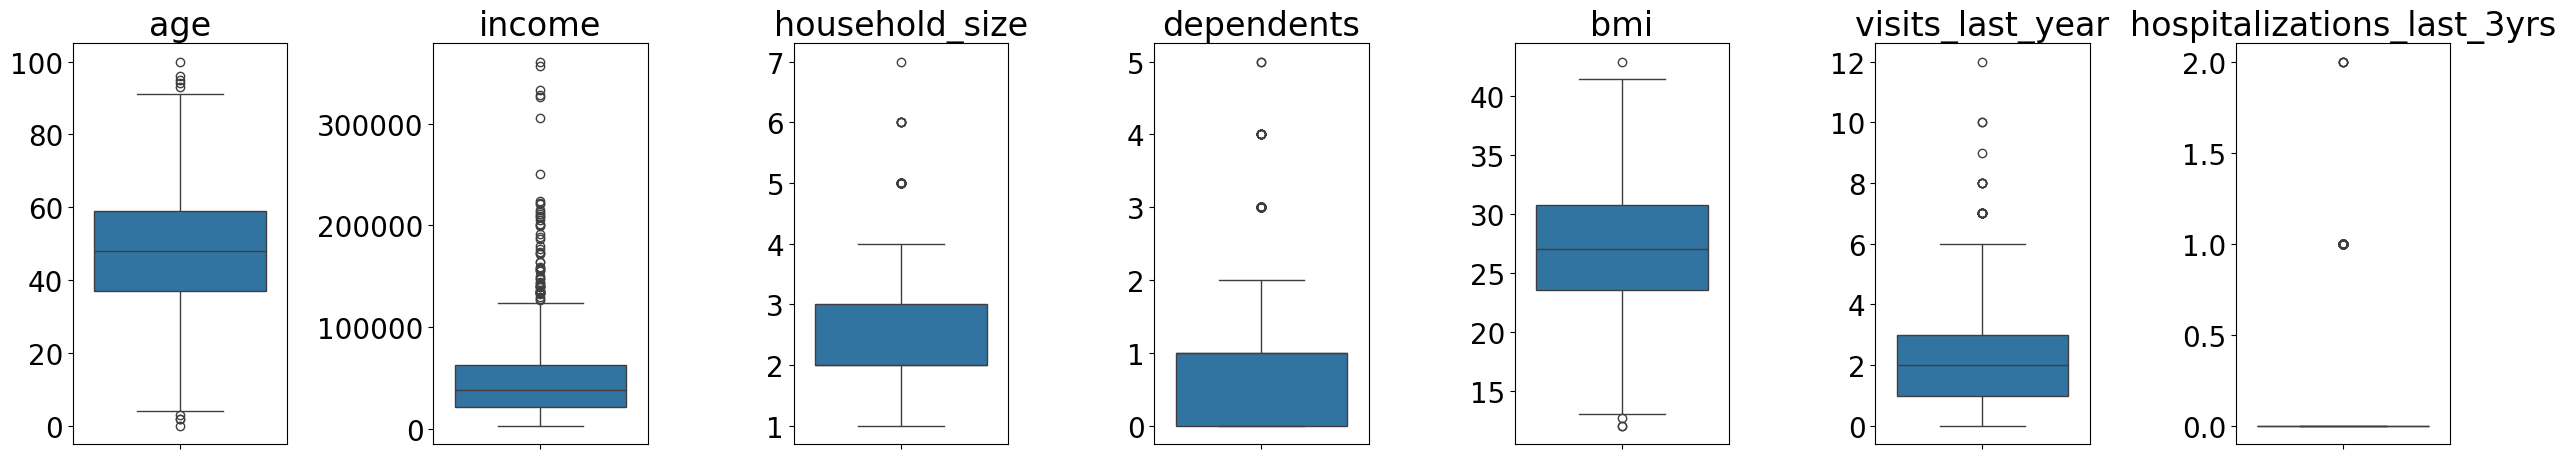

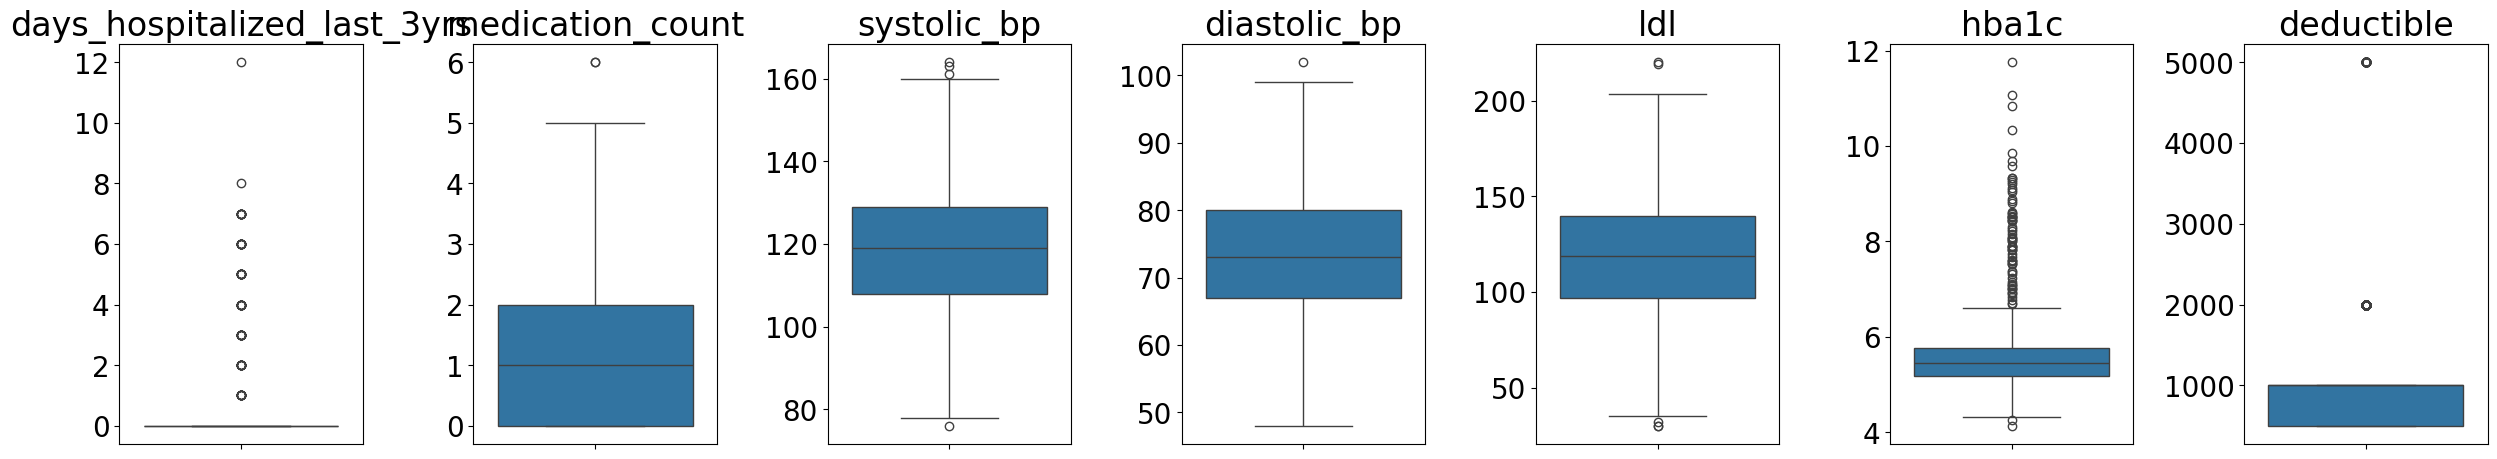

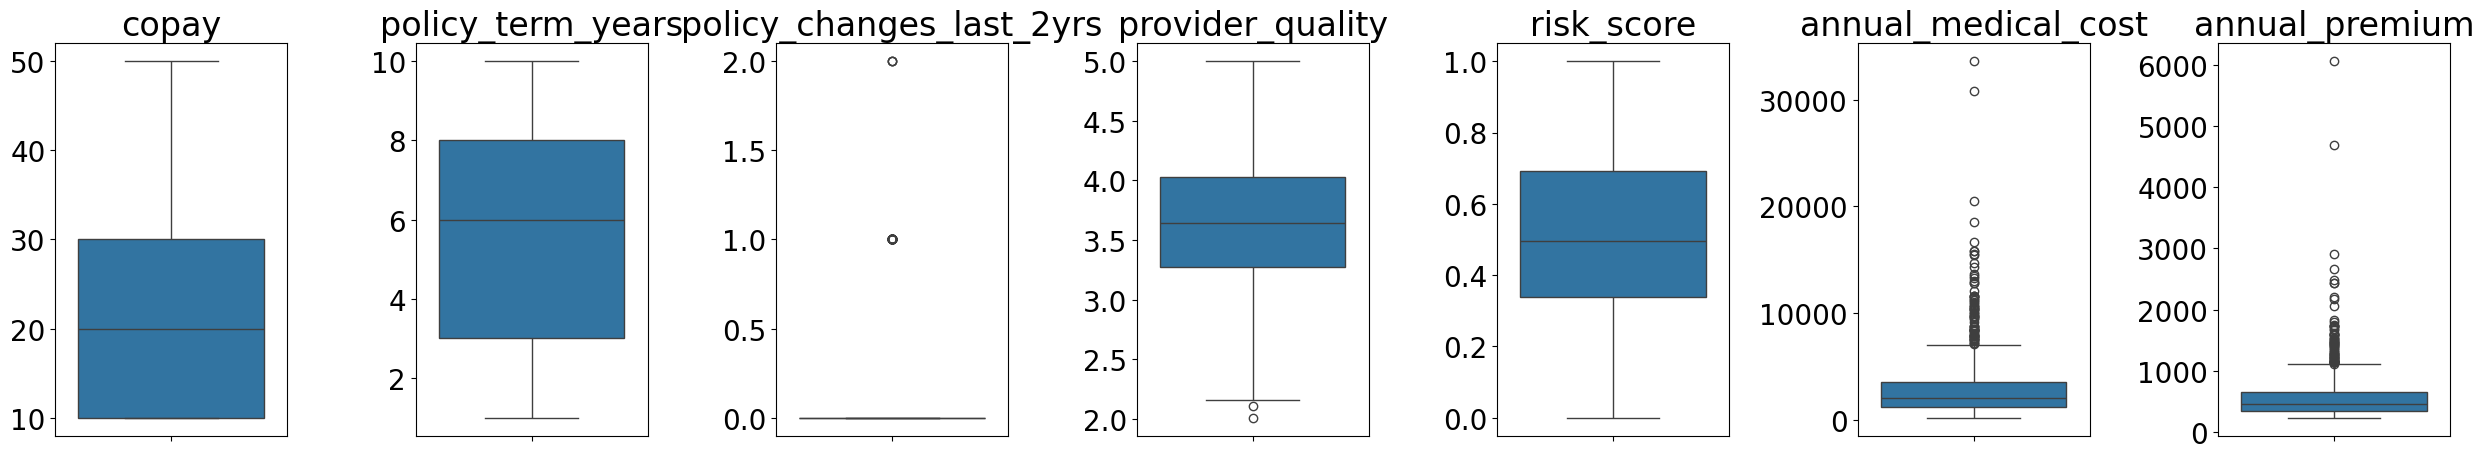

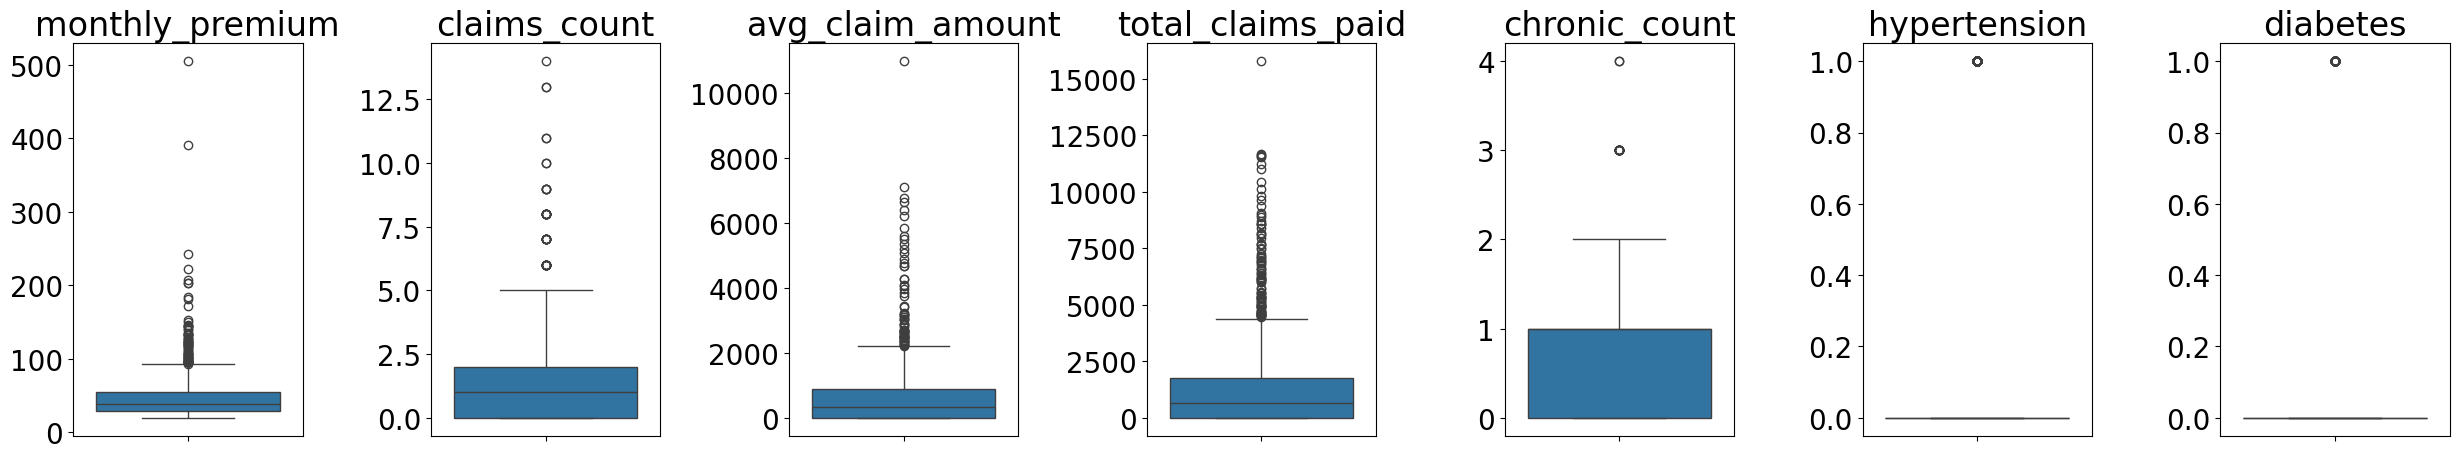

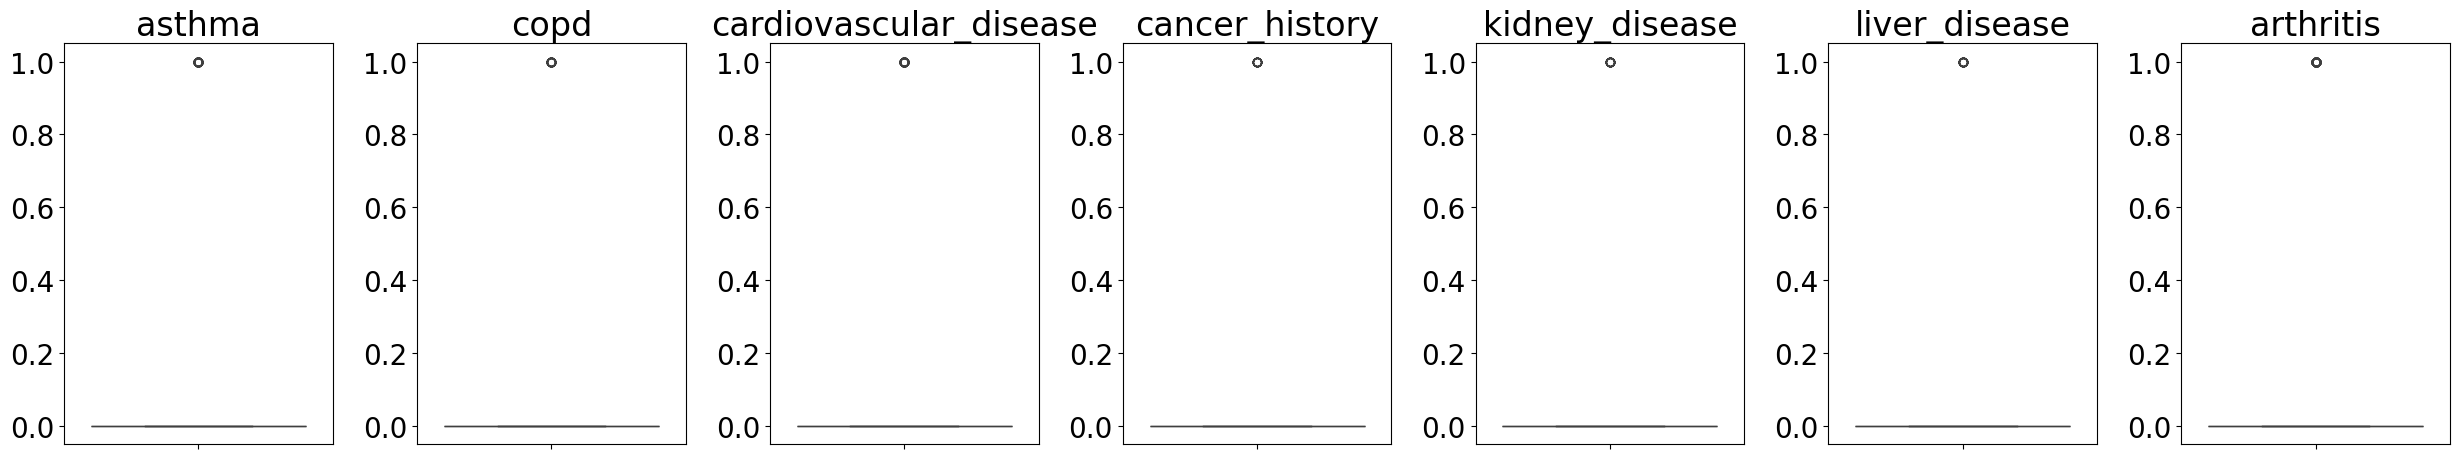

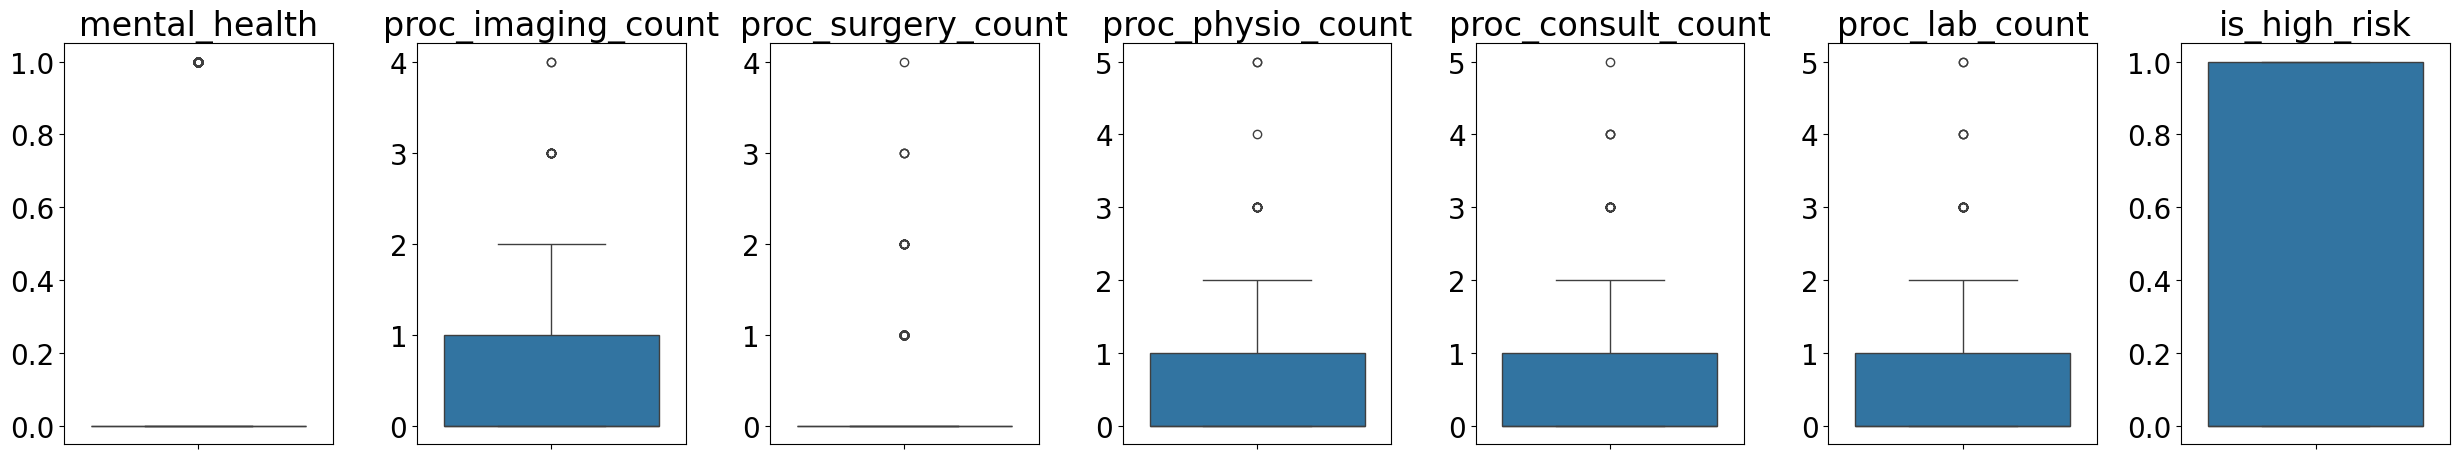

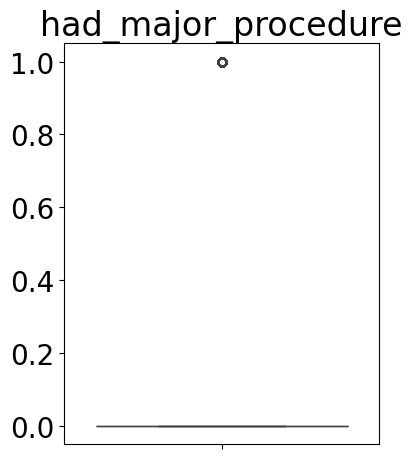

In [135]:
plt.rcParams.update({"font.size": 20})

for round_start in range(0, len(num_features), 7):
    plt.figure(figsize=(25, 5))
    features_chunk = num_features[round_start : round_start + 7]

    for i, feature in enumerate(features_chunk):
        plt.subplot(1, 7, i + 1)
        sns.boxplot(y=X[feature])
        plt.title(feature)
        plt.ylabel("")

    plt.tight_layout()
    plt.show()

In [136]:
features_to_clean = [
    "income",
    "bmi",
    "dependents",
    "visits_last_year",
    "medication_count",
    "systolic_bp",
    "diastolic_bp",
    "ldl",
    "provider_quality",
    "hba1c",
]

In [137]:
df_cleaned = X.copy()

In [138]:
for feature in features_to_clean:
    Q1 = X[feature].quantile(0.25)
    Q3 = X[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    X["z_score"] = np.abs(stats.zscore(X[feature]))

    outliers_z = X[X["z_score"] > Z_THRESHOLD]

    print(
        f"Количество выбросов по методу Z-Score (порог = {Z_THRESHOLD}): {len(outliers_z)}"
    )

    df_cleaned = df_cleaned[
        (df_cleaned[feature] >= lower_bound)
        & (df_cleaned[feature] <= upper_bound)
    ]

Количество выбросов по методу Z-Score (порог = 2.8): 24
Количество выбросов по методу Z-Score (порог = 2.8): 3
Количество выбросов по методу Z-Score (порог = 2.8): 15
Количество выбросов по методу Z-Score (порог = 2.8): 24
Количество выбросов по методу Z-Score (порог = 2.8): 7
Количество выбросов по методу Z-Score (порог = 2.8): 3
Количество выбросов по методу Z-Score (порог = 2.8): 1
Количество выбросов по методу Z-Score (порог = 2.8): 5
Количество выбросов по методу Z-Score (порог = 2.8): 1
Количество выбросов по методу Z-Score (порог = 2.8): 36


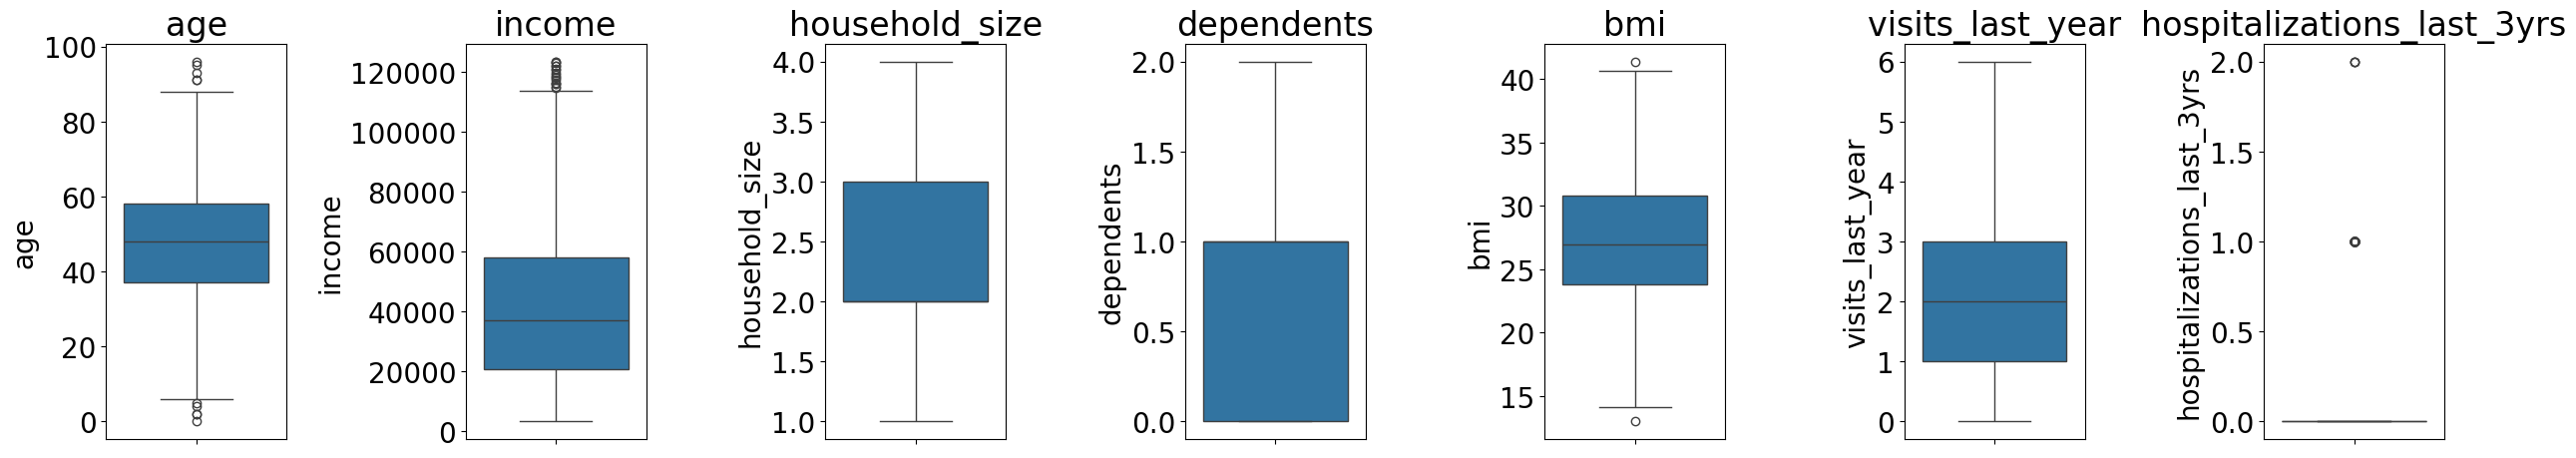

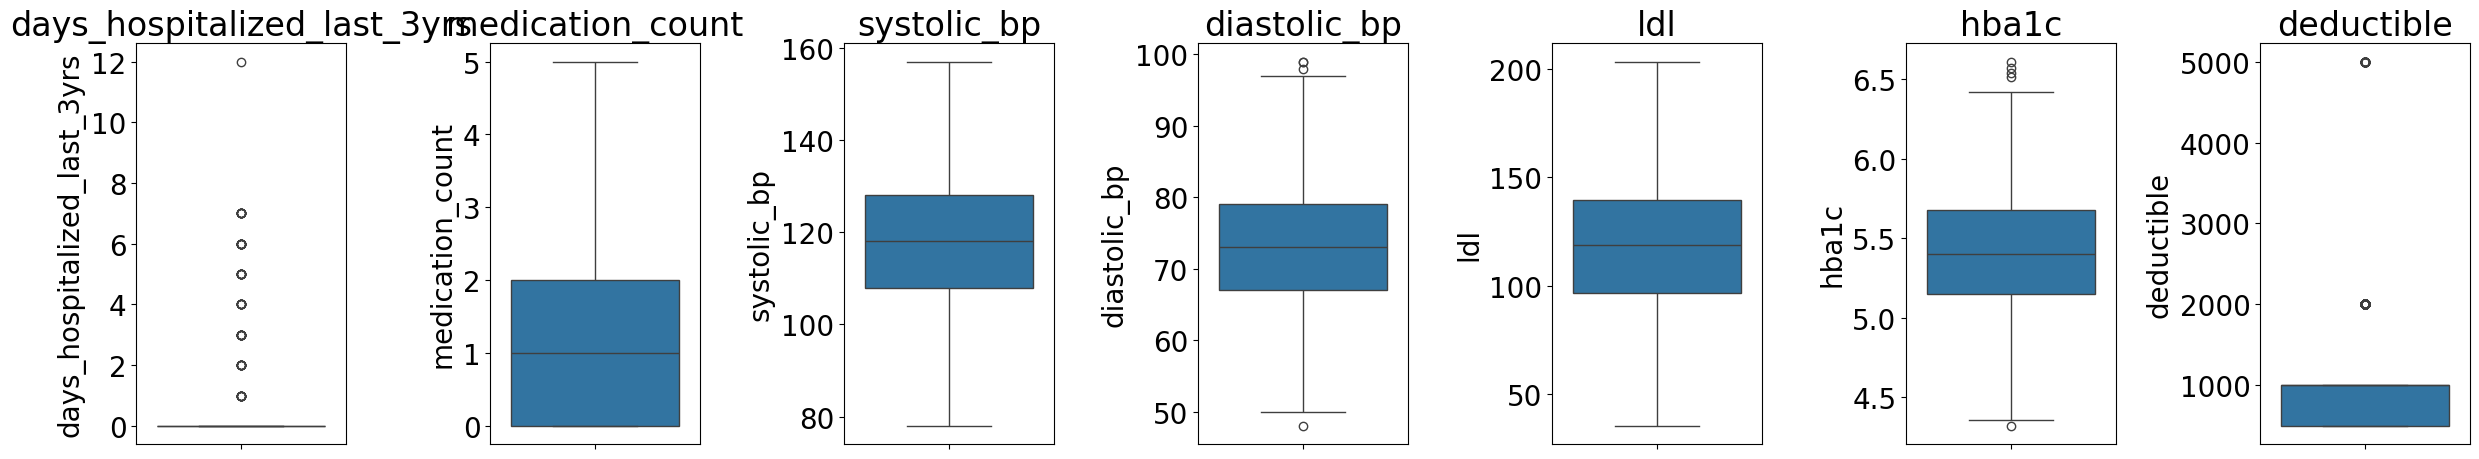

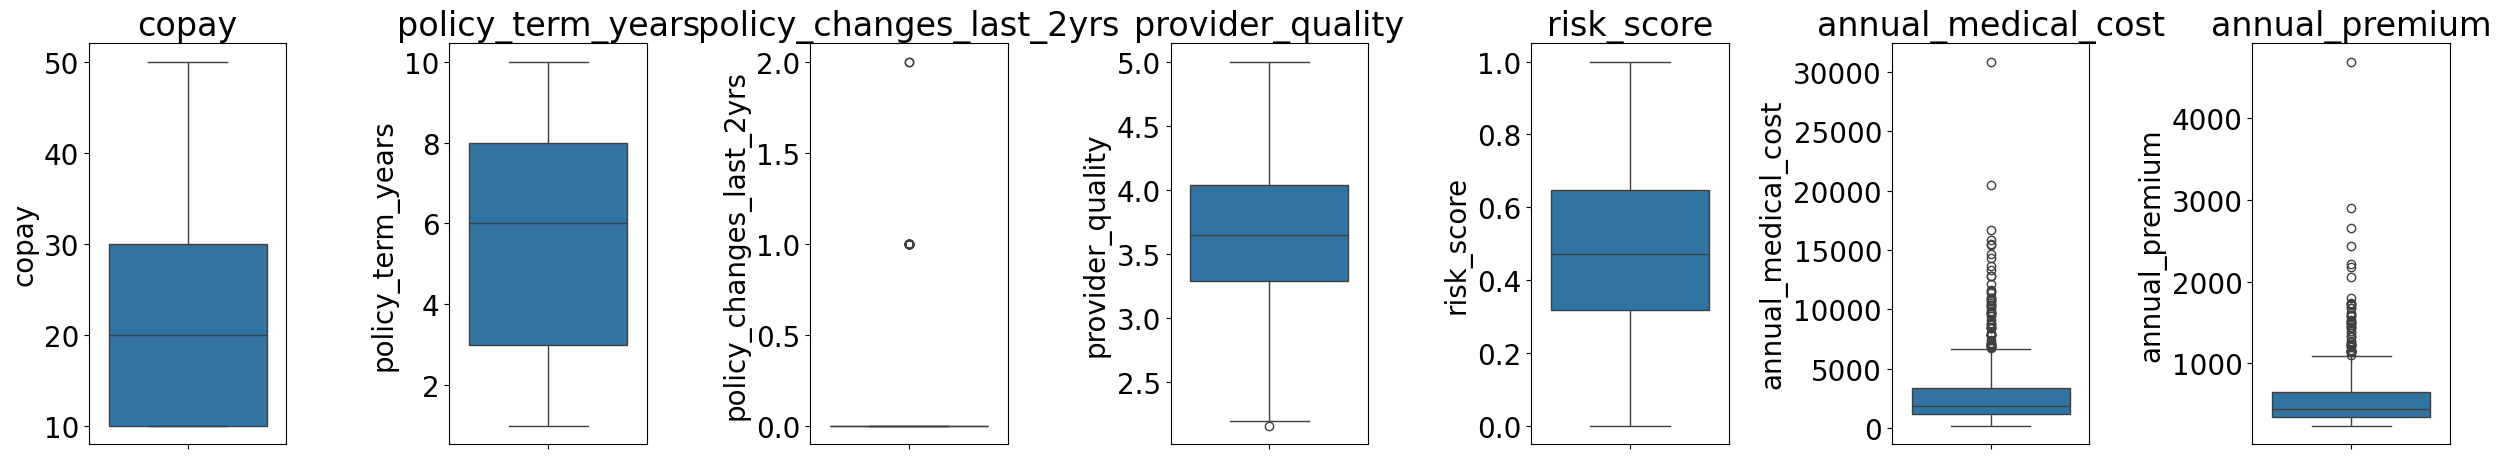

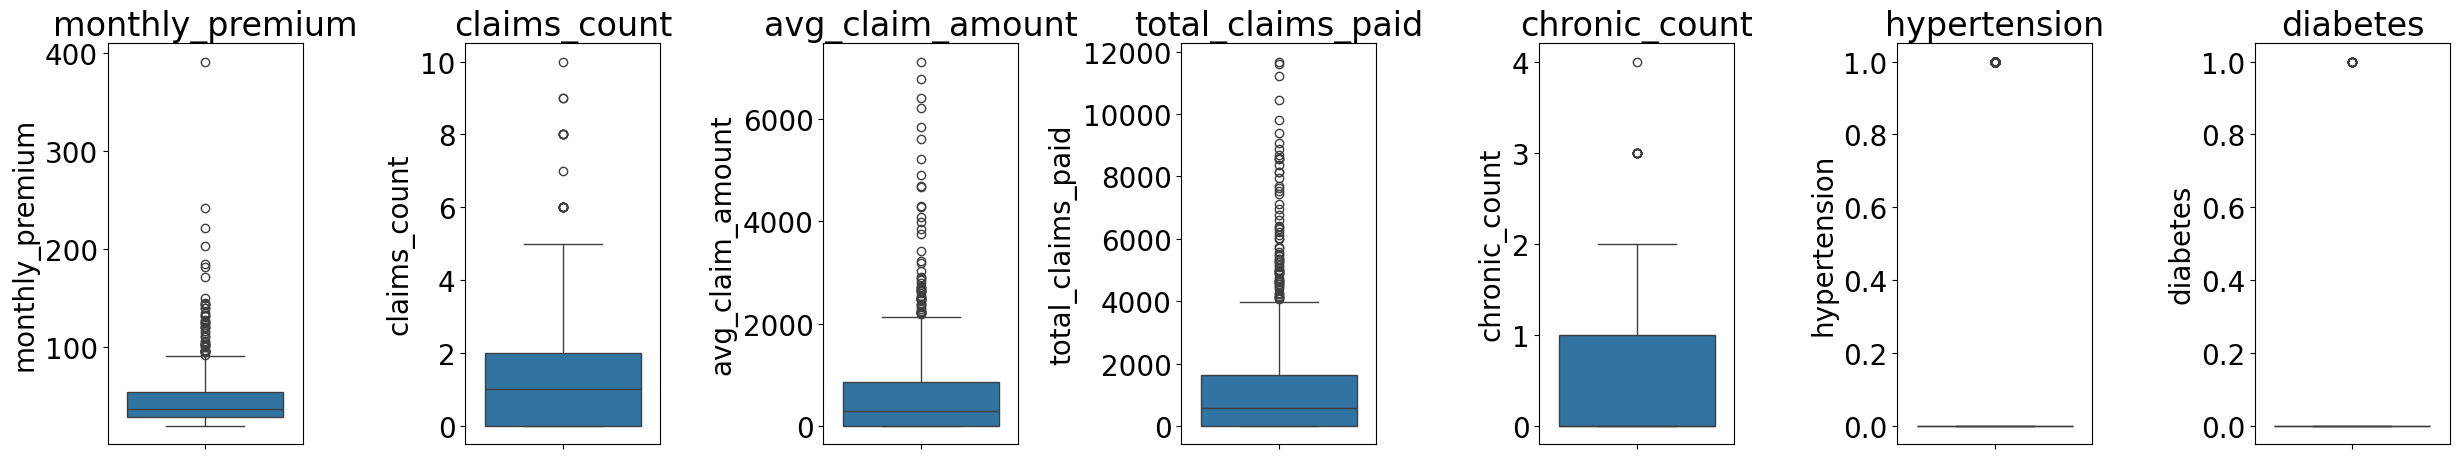

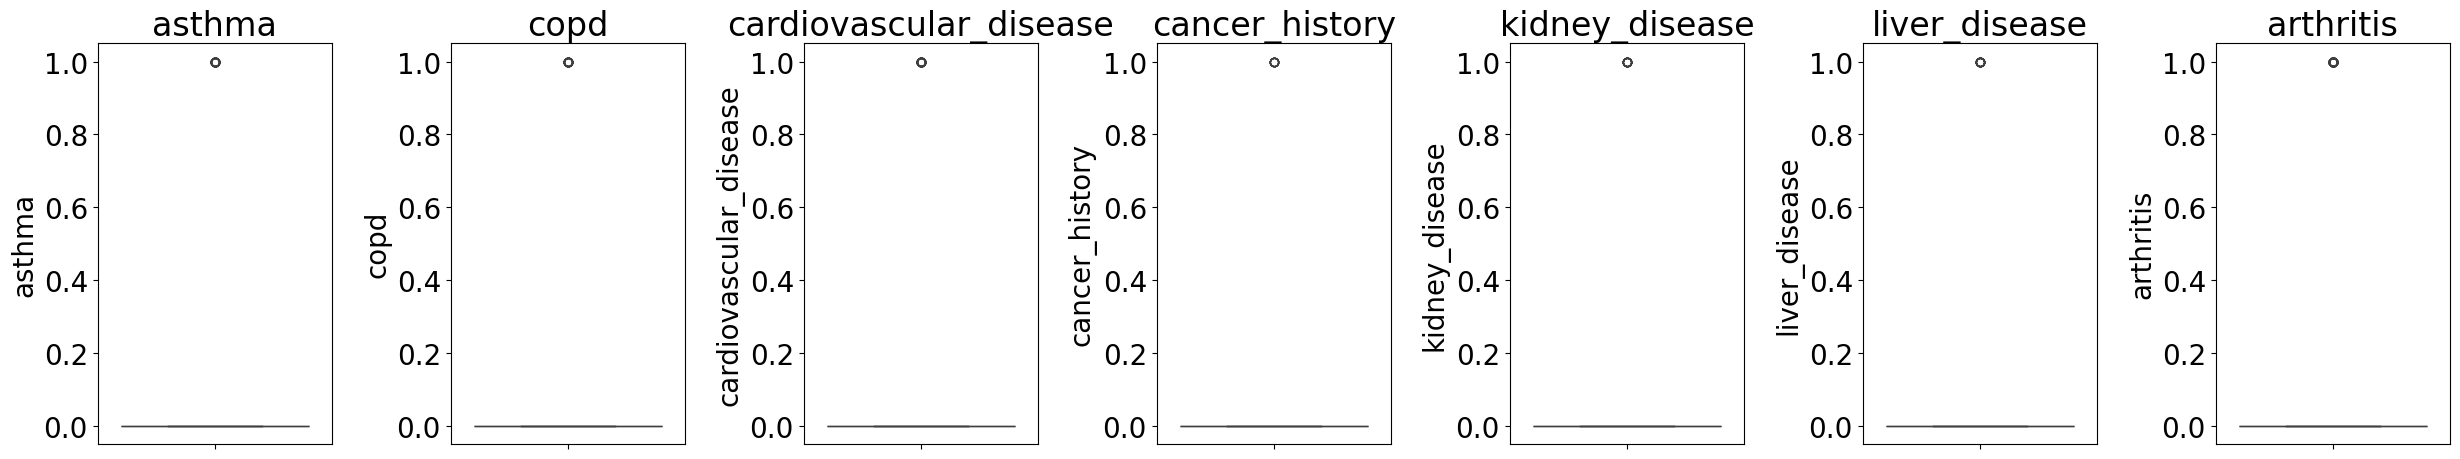

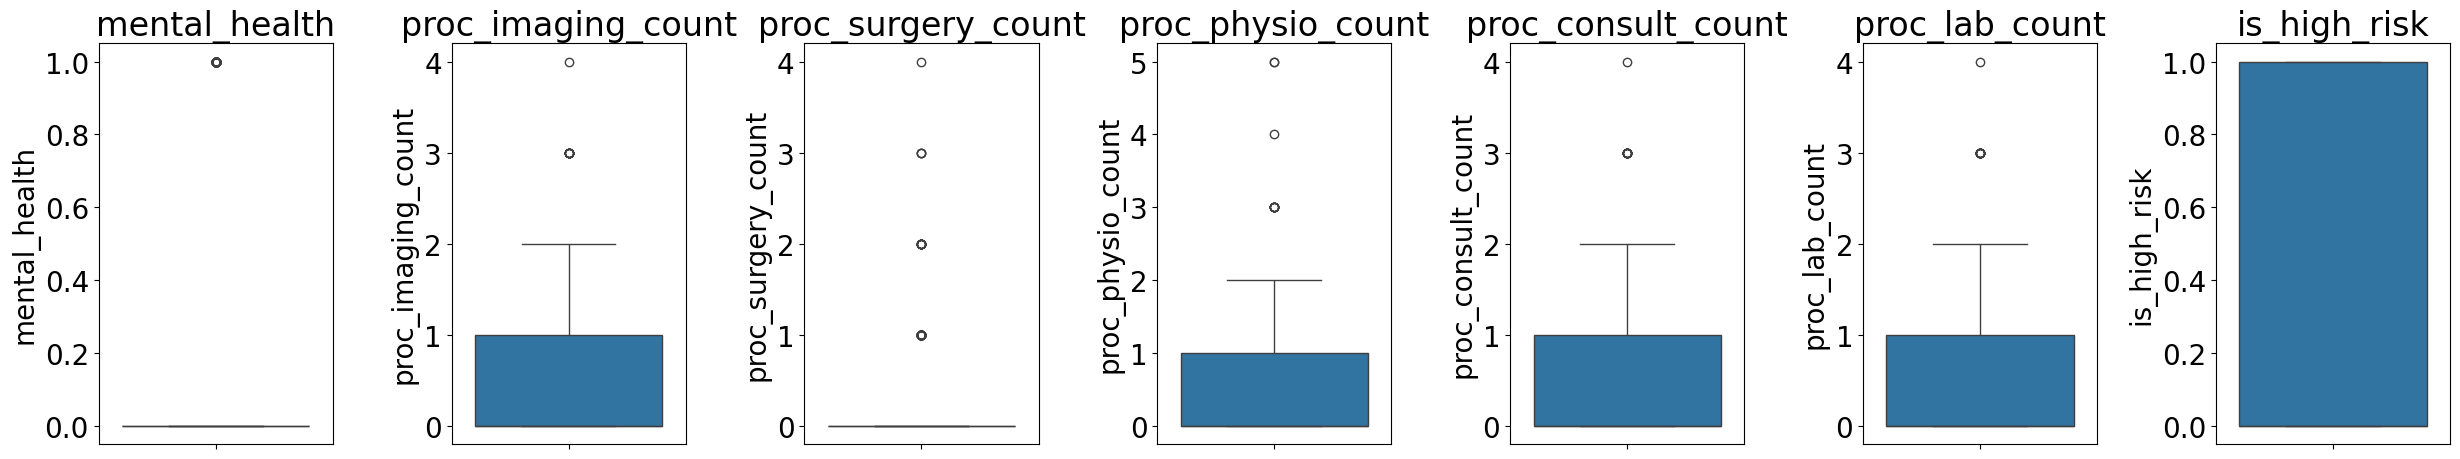

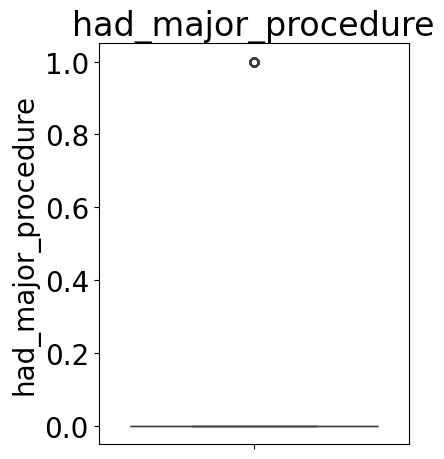

In [139]:
plt.rcParams.update({"font.size": 20})

for round_start in range(0, len(num_features), 7):
    plt.figure(figsize=(25, 5))
    features_chunk = num_features[round_start : round_start + 7]

    for i, feature in enumerate(features_chunk):
        plt.subplot(1, 7, i + 1)
        sns.boxplot(y=df_cleaned[feature])
        plt.title(feature)

    plt.tight_layout()
    plt.show()

картина выбросов стала получше

## 3. ohe

In [140]:
enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded = enc.fit_transform(df_cleaned[cat_features])

encoded_df = pd.DataFrame(
    encoded,
    columns=enc.get_feature_names_out(cat_features),
    index=df_cleaned.index,
)

df_cleaned = pd.concat(
    [df_cleaned.drop(columns=cat_features), encoded_df],
    axis=1,
)

## 4. жадный отбор признаков

In [141]:
Y = df_cleaned["annual_medical_cost"]
X = df_cleaned.drop(columns="annual_medical_cost")

In [142]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 785 entries, 0 to 999
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              785 non-null    int64  
 1   income                           785 non-null    float64
 2   household_size                   785 non-null    int64  
 3   dependents                       785 non-null    int64  
 4   bmi                              785 non-null    float64
 5   visits_last_year                 785 non-null    int64  
 6   hospitalizations_last_3yrs       785 non-null    int64  
 7   days_hospitalized_last_3yrs      785 non-null    int64  
 8   medication_count                 785 non-null    int64  
 9   systolic_bp                      785 non-null    float64
 10  diastolic_bp                     785 non-null    float64
 11  ldl                              785 non-null    float64
 12  hba1c                      

In [143]:
model = RandomForestRegressor(
    random_state=SEED,
    n_estimators=100,
)

In [ ]:
def greedy_feature_selection(
    X: pd.DataFrame,
    Y: pd.DataFrame,
    model,
    cv=5,
):
    features = []
    remaining = list(X.columns)
    best_score = 0
    scores = []

    while remaining:
        best_feature = None
        best_feature_score = best_score

        for f in remaining:
            current_features = features + [f]
            score = cross_val_score(
                model,
                X[current_features],
                Y,
                cv=cv,
                scoring="r2",
                n_jobs=os.cpu_count() - 1,
            ).mean()

            if score > best_feature_score:
                best_feature_score = score
                best_feature = f

        if best_feature is None:
            break

        features.append(best_feature)
        remaining.remove(best_feature)
        best_score = best_feature_score
        scores.append(best_score)

        print(f"add feature: {best_feature:5s} r2: {best_score:.4f}")

    return features, scores

In [145]:
selected_features, scores = greedy_feature_selection(
    X,
    Y,
    model,
    cv=2,
)

add feature: annual_premium r2: 0.8585
add feature: network_tier_Bronze r2: 0.9074
add feature: network_tier_Platinum r2: 0.9345
add feature: liver_disease r2: 0.9364
add feature: network_tier_Silver r2: 0.9364
add feature: cancer_history r2: 0.9382
add feature: education_No HS r2: 0.9394
add feature: smoker_Current r2: 0.9399
add feature: marital_status_Widowed r2: 0.9399


In [146]:
selected_features

['annual_premium',
 'network_tier_Bronze',
 'network_tier_Platinum',
 'liver_disease',
 'network_tier_Silver',
 'cancer_history',
 'education_No HS',
 'smoker_Current',
 'marital_status_Widowed']

In [147]:
scores

[np.float64(0.8585153255631248),
 np.float64(0.9074217656864398),
 np.float64(0.9345082435516945),
 np.float64(0.9364415915657458),
 np.float64(0.9364417282583369),
 np.float64(0.938239123325293),
 np.float64(0.9393684654644249),
 np.float64(0.939871278846948),
 np.float64(0.9399154776078245)]